In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.float_format','{:.2f}'.format)

In [3]:
df = pd.read_excel("./news/news_amg_prices.xlsx", index_col='Date')

In [4]:
df

,Description,Open_amzn,AdjClose_amzn,Open_msft,AdjClose_msft,Open_goog,AdjClose_goog
Date,,,,,,,
2018-03-20,Alphabet Inc's Google is launching the Google...,77.52,79.33,93.05,87.18,54.95,54.89
2018-03-21,"Nordea, the Nordic region's biggest bank, will...",79.32,79.09,92.93,86.57,54.64,54.54
2018-03-22,Investors' expectations for three or four rate...,78.27,77.25,91.27,84.05,54.09,52.45
2018-03-23,The threat of a trade war sent world stock mar...,76.95,74.78,89.50,81.61,52.35,51.08
2018-03-25,The quartet of technology stocks that has driv...,76.95,74.78,89.50,81.61,52.35,51.08
...,...,...,...,...,...,...,...
2020-07-13,The Federal Reserve's $3 trillion bid to stave...,162.55,155.20,214.48,200.27,77.50,75.57
2020-07-14,Alphabet Inc's Google is in advanced talks to ...,154.45,154.20,206.13,201.51,74.52,76.03
2020-07-15,EU antitrust enforcers are asking interested p...,154.01,150.44,209.56,201.21,76.16,75.68


<Axes: xlabel='Date'>

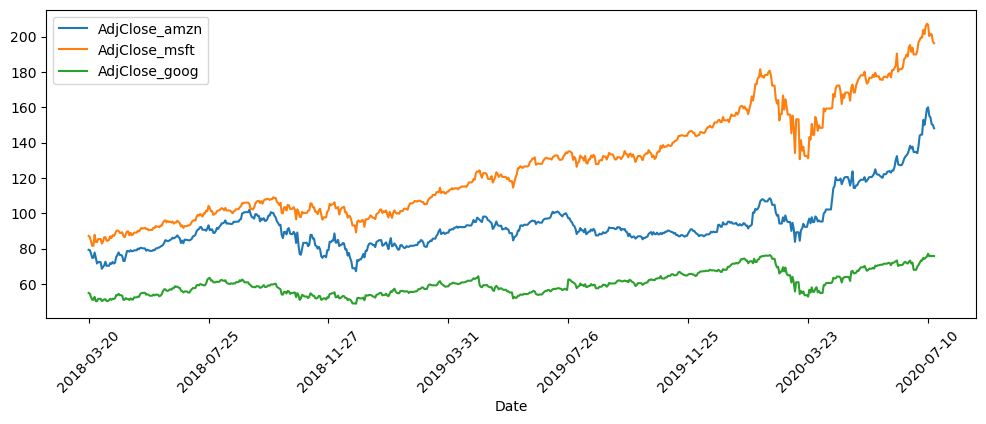

In [5]:
df[['AdjClose_amzn', 'AdjClose_msft', 'AdjClose_goog']].plot(figsize=(12,4), rot=45)

In [6]:
amzn_gain = df['AdjClose_amzn'].iloc[-1]/df['AdjClose_amzn'].iloc[0]
msft_gain = df['AdjClose_msft'].iloc[-1]/df['AdjClose_msft'].iloc[0]
goog_gain = df['AdjClose_goog'].iloc[-1]/df['AdjClose_goog'].iloc[0]
avg_gain = (amzn_gain + msft_gain + goog_gain)/3

print(f"gains: amzn {amzn_gain}, msft {msft_gain}, goog {goog_gain} and avg {avg_gain}")

gains: amzn 1.8669720959842675, msft 2.2507909486118263, goog 1.3806468600760906 and avg 1.832803301557395


In [7]:
#!pip install boto3 awscli botocore

In [8]:
import boto3
import json


In [9]:

#Create the connection to Bedrock
bedrock = boto3.client(
    service_name='bedrock',
    region_name='us-west-2', 
    
)

bedrock_runtime = boto3.client(
    service_name='bedrock-runtime',
    region_name='us-west-2', 
    
)

'''
# Let's see all available Anthropic Models
available_models = bedrock.list_foundation_models()

for model in available_models['modelSummaries']:
  if 'anthropic' in model['modelId']:
    print(model)
'''


"\n# Let's see all available Anthropic Models\navailable_models = bedrock.list_foundation_models()\n\nfor model in available_models['modelSummaries']:\n  if 'anthropic' in model['modelId']:\n    print(model)\n"

In [10]:
import time

In [11]:
#https://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters-anthropic-claude-messages.html


In [12]:
def generate_message(bedrock_runtime, model_id, system_prompt, messages, max_tokens):

    body=json.dumps(
        {
            "anthropic_version": "bedrock-2023-05-31",
            "max_tokens": max_tokens,
            "system": system_prompt,
            "messages": messages
        }  
    )  

    
    response = bedrock_runtime.invoke_model(body=body, modelId=model_id)
    response_body = json.loads(response.get('body').read())
   
    return response_body

In [13]:
def anthropic_claude_3_haiku(statements):

    #print("statements:" + statements)
    
    model_id = 'anthropic.claude-3-haiku-20240307-v1:0'
    system_prompt = "Always print '[Result]' before printing out the final points at step 7." \
        "Use only Amazon, Microsoft, Google, Market for company names at step 7." \
        "Print always all points even if it's 0 at step 7." \
        "Do not use parentheses before and after points"
    max_tokens = 1000

    content = statements \
        + " Given the statements, follow these steps" \
        + " 1. categorize and present the statements into positive, negative, neutral to Amazon, Microsoft, Google stocks and entire stock market named Market." \
        + " 2. give 0 point for Amazon, Microsoft, Google and Market" \
        + " 3. add 1 point to the company points if a postive statement is specific to a company." \
        + " 4. subtract 1 point from the company points if a negative statement is specific to a company." \
        + " 5. add 1 points to Market if a positive statement is for entire stock market." \
        + " 6. subtract 1 points from Market if a negative statement is for entire stock market." \
        + " 7. print out the final points in company name:number format in Amazon, Microsoft, Google, Market order."
    

    user_message =  {"role": "user", "content": content}
    messages = [user_message]
    start = time.time()
    response = generate_message (bedrock_runtime, model_id, system_prompt, messages, max_tokens)
    end = time.time()

    content_text = response.get("content")[0]['text']

    if ( (end - start) > 10 ):
        print(f"\ninvocation time warning {(end - start)} secs")
    else:
        print('.', end='') # progress bar

    return content_text

In [14]:
'''
claude_responses = pd.DataFrame(data=df['Description']).copy(deep=True)
claude_responses['response'] = ""
claude_responses['result'] = ""

claude_responses['amzn'] = 0
claude_responses['msft'] = 0
claude_responses['goog'] = 0
claude_responses['market'] = 0
'''
claude_responses = pd.read_excel("./news/claude_responses_raw.xlsx", index_col='Date')

claude_responses

,Description,response,result,amzn,msft,goog,market
Date,,,,,,,
2018-03-20,Alphabet Inc's Google is launching the Google...,[Result]\n\nPositive Statements:\n- A rise in ...,\n\nPositive Statements:\n- A rise in oil pric...,0.00,0.00,-1.00,1.00
2018-03-21,"Nordea, the Nordic region's biggest bank, will...",Here are the statements categorized into posit...,\nAmazon:0\nMicrosoft:0\nGoogle:0\nMarket:0,0.00,0.00,0.00,0.00
2018-03-22,Investors' expectations for three or four rate...,[Result]\nAmazon:0\nMicrosoft:0\nGoogle:0\nMar...,\nAmazon:0\nMicrosoft:0\nGoogle:0\nMarket:-2,0.00,0.00,0.00,-2.00
2018-03-23,The threat of a trade war sent world stock mar...,Analyzing the statements:\n\nNegative statemen...,\nAmazon:0 Microsoft:0 Google:0 Market:-1,0.00,0.00,0.00,-1.00
2018-03-25,The quartet of technology stocks that has driv...,Categorization of statements:\n\nPositive: Non...,\nAmazon:0 Microsoft:0 Google:0 Market:0,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...
2020-07-13,The Federal Reserve's $3 trillion bid to stave...,Here are the steps:\n\n1. Categorizing the sta...,\nAmazon:0\nMicrosoft:0\nGoogle:1\nMarket:-1,0.00,0.00,1.00,-1.00
2020-07-14,Alphabet Inc's Google is in advanced talks to ...,"Based on the given statements, here is the cat...",\nAmazon:0\nMicrosoft:0\nGoogle:0\nMarket:-3,0.00,0.00,0.00,-3.00
2020-07-15,EU antitrust enforcers are asking interested p...,[Result]\nPositive statements:\n- Alphabet Inc...,\nPositive statements:\n- Alphabet Inc's Googl...,0.00,0.00,2.00,1.00


In [15]:
#claude_responses = claude_responses[:10]
#claude_responses

In [16]:
'''
 call the llm for the entire row
'''
#claude_responses.loc[:, 'response'] = claude_responses['Description'].apply(anthropic_claude_3_haiku)

'\n call the llm for the entire row\n'

In [17]:
'''
single call test
'''
#print(claude_responses.iloc[8]['Description'])
#print(anthropic_claude_3_haiku(claude_responses.iloc[8]['Description']))


'\nsingle call test\n'

In [18]:
claude_responses.to_excel("./news/claude_responses_raw.xlsx")

In [19]:
claude_responses

,Description,response,result,amzn,msft,goog,market
Date,,,,,,,
2018-03-20,Alphabet Inc's Google is launching the Google...,[Result]\n\nPositive Statements:\n- A rise in ...,\n\nPositive Statements:\n- A rise in oil pric...,0.00,0.00,-1.00,1.00
2018-03-21,"Nordea, the Nordic region's biggest bank, will...",Here are the statements categorized into posit...,\nAmazon:0\nMicrosoft:0\nGoogle:0\nMarket:0,0.00,0.00,0.00,0.00
2018-03-22,Investors' expectations for three or four rate...,[Result]\nAmazon:0\nMicrosoft:0\nGoogle:0\nMar...,\nAmazon:0\nMicrosoft:0\nGoogle:0\nMarket:-2,0.00,0.00,0.00,-2.00
2018-03-23,The threat of a trade war sent world stock mar...,Analyzing the statements:\n\nNegative statemen...,\nAmazon:0 Microsoft:0 Google:0 Market:-1,0.00,0.00,0.00,-1.00
2018-03-25,The quartet of technology stocks that has driv...,Categorization of statements:\n\nPositive: Non...,\nAmazon:0 Microsoft:0 Google:0 Market:0,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...
2020-07-13,The Federal Reserve's $3 trillion bid to stave...,Here are the steps:\n\n1. Categorizing the sta...,\nAmazon:0\nMicrosoft:0\nGoogle:1\nMarket:-1,0.00,0.00,1.00,-1.00
2020-07-14,Alphabet Inc's Google is in advanced talks to ...,"Based on the given statements, here is the cat...",\nAmazon:0\nMicrosoft:0\nGoogle:0\nMarket:-3,0.00,0.00,0.00,-3.00
2020-07-15,EU antitrust enforcers are asking interested p...,[Result]\nPositive statements:\n- Alphabet Inc...,\nPositive statements:\n- Alphabet Inc's Googl...,0.00,0.00,2.00,1.00


In [20]:
print(claude_responses.iloc[5]['response'])

Categorization of statements:

Positive statements:
- Shoppers are making more quick trips to Whole Foods stores that have installed Amazon.com lockers, giving the natural and organic retailer a new way to boost sales.
- Stocks rose almost everywhere on Monday, reflecting optimism that the United States and China are set to begin negotiations on trade.

Negative statements:
- Banks should adopt compensation plans that discourage excessive risk-taking and place greater onus on senior managers for wrongdoing, the outgoing head of the New York Federal Reserve said on Monday.

Neutral statements:
- Goldman Sachs Group Inc pays employees a much bigger portion in stock than Wall Street rivals, a trend that has come into sharper focus as the bank overhauls its business strategy.

Points calculation:

Amazon: 1 (positive statement specific to Amazon)
Microsoft: 0
Google: 0
Market: 1 (positive statement for entire stock market)

Final points:
[Result]
Amazon:1
Microsoft:0
Google:0
Market:1


In [21]:
claude_responses.loc[:, 'result'] = claude_responses['response'].str.split(r"\[Result\]").str[1]

In [22]:
'''
amzn = pd.Series(claude_responses['result'].str.extract(r"Amazon\: *([+|-]*[0-9]+)")[0])
claude_responses[amzn.isnull()]['result'].to_excel("claude_responses_amzn_nulls.xlsx")
msft = pd.Series(claude_responses['result'].str.extract(r"Microsoft\: *([+|-]*[0-9]+)")[0])
claude_responses[msft.isnull()]['result'].to_excel("claude_responses_msft_nulls.xlsx")
goog = pd.Series(claude_responses['result'].str.extract(r"Google\: *([+|-]*[0-9]+)")[0])
claude_responses[goog.isnull()]['result'].to_excel("claude_responses_goog_nulls.xlsx")
market = pd.Series(claude_responses['result'].str.extract(r"Market\: *([+|-]*[0-9]+)")[0])
claude_responses[market.isnull()]['result'].to_excel("claude_responses_market_nulls.xlsx")
'''

'\namzn = pd.Series(claude_responses[\'result\'].str.extract(r"Amazon\\: *([+|-]*[0-9]+)")[0])\nclaude_responses[amzn.isnull()][\'result\'].to_excel("claude_responses_amzn_nulls.xlsx")\nmsft = pd.Series(claude_responses[\'result\'].str.extract(r"Microsoft\\: *([+|-]*[0-9]+)")[0])\nclaude_responses[msft.isnull()][\'result\'].to_excel("claude_responses_msft_nulls.xlsx")\ngoog = pd.Series(claude_responses[\'result\'].str.extract(r"Google\\: *([+|-]*[0-9]+)")[0])\nclaude_responses[goog.isnull()][\'result\'].to_excel("claude_responses_goog_nulls.xlsx")\nmarket = pd.Series(claude_responses[\'result\'].str.extract(r"Market\\: *([+|-]*[0-9]+)")[0])\nclaude_responses[market.isnull()][\'result\'].to_excel("claude_responses_market_nulls.xlsx")\n'

In [23]:

claude_responses.loc[:, 'amzn'] = claude_responses['result'].str.extract(r"Amazon\: *([+|-]*[0-9]+)")[0]
claude_responses.loc[:, 'msft'] = claude_responses['result'].str.extract(r"Microsoft\: *([+|-]*[0-9]+)")[0]
claude_responses.loc[:, 'goog'] = claude_responses['result'].str.extract(r"Google\: *([+|-]*[0-9]+)")[0]
claude_responses.loc[:, 'market'] = claude_responses['result'].str.extract(r"Market\: *([+|-]*[0-9]+)")[0]


/tmp/ipykernel_13263/1127169267.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['0' '0' '0' '0' '0' '1' '2' '-1' '-2' '-1' '-1' '-4' '0' '1' '0' '0' '0'
 '0' '0' '0' nan '0' '1' '1' '1' '1' '0' '1' '0' '0' '0' '0' '3' '0' '0'
 '0' '1' '-1' '0' '-1' '0' '1' '0' '1' '0' '0' '0' '0' '1' '-1' '0' '-1'
 '0' '0' '0' nan '0' '0' '0' '0' nan '0' '0' '0' '0' '0' nan '0' '0' '0'
 '1' '0' '0' '0' '+1' '0' '0' '0' '0' '0' '1' '0' '0' '0' '0' '0' '0' '0'
 nan nan '0' '0' '-1' '1' '1' '0' '0' '0' '0' '0' '0' '1' '1' nan '0' '0'
 '1' '0' nan '0' '0' '1' nan '0' '1' nan '0' '0' '0' '0' '0' '1' '0' '-1'
 '0' '0' nan '0' '0' '0' '-1' '0' '0' '0' '1' '0' nan '0' '0' '0' '0' '1'
 '0' '0' '1' '-1' '1' '0' '0' '0' '0' '0' '1' '-1' '0' '1' '0' '-1' '0'
 '0' '0' '0' '0' '0' nan '0' '0' '0' '0' '0' '0' '1' '0' '0' '-1' '-1' '0'
 '1' '0' '-1' '0' '0' '1' '+1' '0' '0' nan '1' '0' '0' '-1' '0' '0' '0'
 '0' '0' '1' '0' '0' '0' '1' '0' '0'

In [24]:
claude_responses.isna().sum()

Description     0
response        0
result         28
amzn           38
msft           37
goog           33
market         34
dtype: int64

In [25]:
claude_responses = claude_responses.fillna(0)
claude_responses['amzn'] = claude_responses['amzn'].astype(int)
claude_responses['msft'] = claude_responses['msft'].astype(int)
claude_responses['goog'] = claude_responses['goog'].astype(int)
claude_responses['market'] = claude_responses['market'].astype(int)

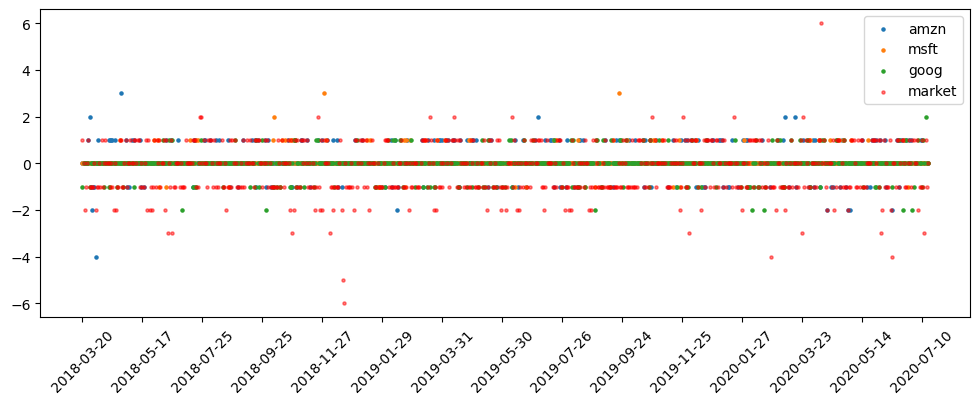

In [26]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 1, 1)
plt.scatter(claude_responses.index, claude_responses['amzn'], label="amzn", s=5)
plt.scatter(claude_responses.index, claude_responses['msft'], label="msft", s=5)
plt.scatter(claude_responses.index, claude_responses['goog'], label="goog", s=5)
plt.scatter(claude_responses.index, claude_responses['market'], label="market", s=5, alpha=0.5, color="red")
plt.xticks(rotation = 45)
ax.set_xticks(ax.get_xticks()[::50])
plt.legend()
plt.show()

<Axes: xlabel='Date'>

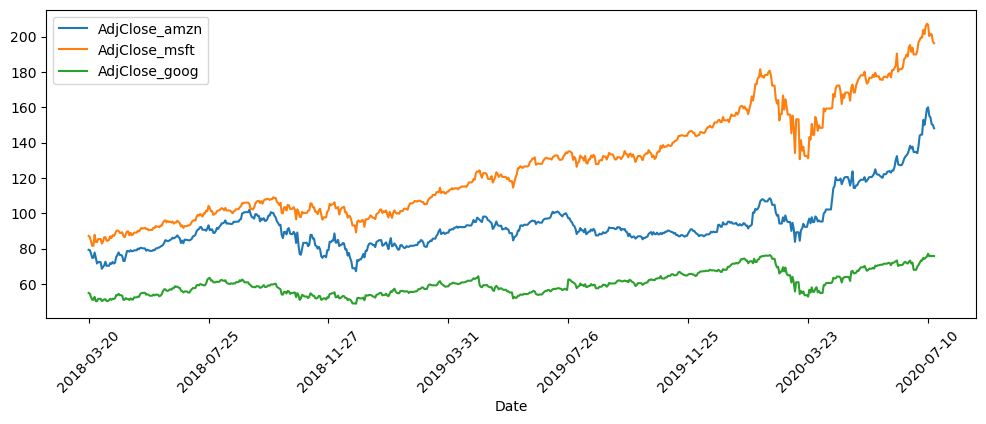

In [27]:
df[['AdjClose_amzn', 'AdjClose_msft', 'AdjClose_goog']].plot(figsize=(12,4), rot=45)

In [28]:
claude_responses[['amzn', 'msft', 'goog', 'market']].sum()

amzn       54
msft       37
goog      -40
market   -173
dtype: int64

In [29]:
'''

my order

'''

'\n\nmy order\n\n'

In [30]:
orders = pd.DataFrame(data=claude_responses[['amzn', 'msft', 'goog', 'market']]).copy(deep=True)
orders['o(a)'] = 0.0
orders['o(m)'] = 0.0
orders['o(g)'] = 0.0

In [31]:
orders.loc[orders.index[0], 'o(a)'] = 30.0
orders.loc[orders.index[0], 'o(m)'] = 30.0
orders.loc[orders.index[0], 'o(g)'] = 30.0

In [32]:
cf = 1
mf = 0.05
yesterday = orders.index[0]
for date in orders.index[1:]:
    
    o_a = max(orders.loc[yesterday,'o(a)'] + orders.loc[date,'amzn'] * cf + orders.loc[date,'market'] * mf, 0)
    o_m = max(orders.loc[yesterday,'o(m)'] + orders.loc[date,'msft'] * cf + orders.loc[date,'market'] * mf, 0)
    o_g = max(orders.loc[yesterday,'o(g)'] + orders.loc[date,'goog'] * cf + orders.loc[date,'market'] * mf, 0)
    
    #scale if sum > 100
    o_sum = o_a + o_m + o_g
    if ( o_sum > 100 ):
        o_a = o_a * 100 / o_sum
        o_m = o_m * 100 / o_sum
        o_g = o_g * 100 / o_sum
    
    orders.loc[date,'o(a)'] = o_a
    orders.loc[date,'o(m)'] = o_m
    orders.loc[date,'o(g)'] = o_g
    
    # for next look
    yesterday = date


In [33]:
orders

,amzn,msft,goog,market,o(a),o(m),o(g)
Date,,,,,,,
2018-03-20,0,0,-1,1,30.00,30.00,30.00
2018-03-21,0,0,0,0,30.00,30.00,30.00
2018-03-22,0,0,0,-2,29.90,29.90,29.90
2018-03-23,0,0,0,-1,29.85,29.85,29.85
2018-03-25,0,0,0,0,29.85,29.85,29.85
...,...,...,...,...,...,...,...
2020-07-13,0,0,1,-1,55.58,43.47,0.95
2020-07-14,0,0,0,-3,55.43,43.32,0.80
2020-07-15,0,0,2,1,54.55,42.65,2.80


<Axes: xlabel='Date'>

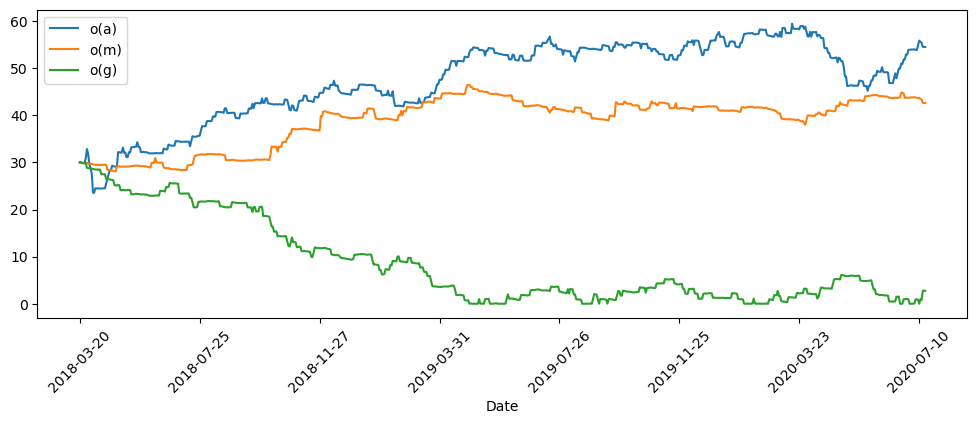

In [34]:
orders[['o(a)', 'o(m)', 'o(g)']].plot(figsize=(12,4), rot=45)

In [35]:
def evaluate_orders(orders):
    #initial cash
    initial_cash = 1000000
    
    book = \
    df[['Open_amzn', 'AdjClose_amzn', 'Open_msft', 'AdjClose_msft', 'Open_goog', 'AdjClose_goog']].copy(deep=True)
    
    book['o(a)'] = np.nan
    book['o(m)'] = np.nan
    book['o(g)'] = np.nan
    book['cash'] = 0.0
    book['u(a)'] = 0
    book['u(m)'] = 0
    book['u(g)'] = 0
    book['value'] = 0.0

    book.loc[book.index[0], 'cash'] = initial_cash
    book.loc[book.index[0], 'value'] = book.loc[book.index[0], 'cash'] \
        + book.loc[book.index[0], 'AdjClose_amzn'] * book.loc[book.index[0], 'u(a)'] \
        + book.loc[book.index[0], 'AdjClose_msft'] * book.loc[book.index[0], 'u(m)'] \
        + book.loc[book.index[0], 'AdjClose_goog'] * book.loc[book.index[0], 'u(g)']

    #insert orders
    book.loc[:, 'o(a)'] = orders['o(a)']
    book.loc[:, 'o(m)'] = orders['o(m)']
    book.loc[:, 'o(g)'] = orders['o(g)']

    #keep rasio for days without new orders
    book['o(a)'] = book['o(a)'].ffill()
    book['o(m)'] = book['o(m)'].ffill()
    book['o(g)'] = book['o(g)'].ffill()
    
    #calculate values
    order_date = book.index[0]
    #print(order_date)
    for date in book.index[1:]:
        #print(date)
        value = book.loc[order_date, 'cash']
        # for simple calculation, sell all at same price to buy then rebuy as order
        value += book.loc[order_date, 'u(a)'] * book.loc[date, 'Open_amzn']
        value += book.loc[order_date, 'u(m)'] * book.loc[date, 'Open_msft']
        value += book.loc[order_date, 'u(g)'] * book.loc[date, 'Open_goog']
        #print("value:" + str(value))
        cash = value
        # buy as order
        order = book.loc[order_date, 'o(a)']
        price = book.loc[date, 'Open_amzn']
        pay = value * order / 100
        book.loc[date, 'u(a)'] = pay // price
        cash = cash - pay + (pay % price)
        #print(f"a o:{order} p:{price} pay:{pay} u(a): {book.loc[date, 'u(a)']} cash: {cash}")

        order = book.loc[order_date, 'o(m)']
        price = book.loc[date, 'Open_msft']
        pay = value * order / 100
        book.loc[date, 'u(m)'] = pay // price
        cash = cash - pay + (pay % price)
        #print(f"m o:{order} p:{price} pay:{pay} u(m): {book.loc[date, 'u(m)']} cash: {cash}")

        order = book.loc[order_date, 'o(g)']
        price = book.loc[date, 'Open_goog']
        pay = value * order / 100
        book.loc[date, 'u(g)'] = pay // price
        cash = cash - pay + (pay % price)
        #print(f"g o:{order} p:{price} pay:{pay} u(g): {book.loc[date, 'u(g)']} cash: {cash}")

        book.loc[date, 'cash'] = cash
        book.loc[date, 'value'] = book.loc[date, 'cash'] \
            + book.loc[date, 'u(a)'] * book.loc[date, 'AdjClose_amzn'] \
            + book.loc[date, 'u(m)'] * book.loc[date, 'AdjClose_msft'] \
            + book.loc[date, 'u(g)'] * book.loc[date, 'AdjClose_goog']
        #print(f"cash {cash} value {book.loc[date, 'value']}")
        # set order date for the next day
        order_date = date
    
    return book

In [36]:
'''
base line 1
'''

bl1_order = pd.DataFrame(data=np.nan, index=df.index, columns=['o(a)', 'o(m)', 'o(g)'])
bl1_order.loc[bl1_order.index[0], 'o(a)'] = 33.333333
bl1_order.loc[bl1_order.index[0], 'o(m)'] = 33.333333
bl1_order.loc[bl1_order.index[0], 'o(g)'] = 33.333333

In [37]:
bl1_book = evaluate_orders(bl1_order)

cash = bl1_book.iloc[1]['cash']
u_a = bl1_book.iloc[1]['u(a)']
u_m = bl1_book.iloc[1]['u(m)']
u_g = bl1_book.iloc[1]['u(g)']
for date in bl1_book.index[2:]:
    bl1_book.loc[date, 'o(a)'] = np.nan 
    bl1_book.loc[date, 'o(m)'] = np.nan 
    bl1_book.loc[date, 'o(g)'] = np.nan
    bl1_book.loc[date, 'cash'] = cash 
    bl1_book.loc[date, 'u(a)'] = u_a 
    bl1_book.loc[date, 'u(m)'] = u_m
    bl1_book.loc[date, 'u(g)'] = u_g
    bl1_book.loc[date, 'value'] = cash \
        + bl1_book.loc[date, 'AdjClose_amzn'] * bl1_book.loc[date, 'u(a)'] \
        + bl1_book.loc[date, 'AdjClose_msft'] * bl1_book.loc[date, 'u(m)'] \
        + bl1_book.loc[date, 'AdjClose_goog'] * bl1_book.loc[date, 'u(g)']

In [38]:
'''
base line 2
'''
bl2_order = pd.DataFrame(data=np.nan, index=df.index, columns=['o(a)', 'o(m)', 'o(g)'])

bl2_order.loc[bl2_order.index[0], 'o(a)'] = 30.0
bl2_order.loc[bl2_order.index[0], 'o(m)'] = 30.0
bl2_order.loc[bl2_order.index[0], 'o(g)'] = 30.0

In [39]:
bl2_book = evaluate_orders(bl2_order)

In [40]:
my_order = orders
my_book = evaluate_orders(my_order)

your gain: 1.8618508440069952


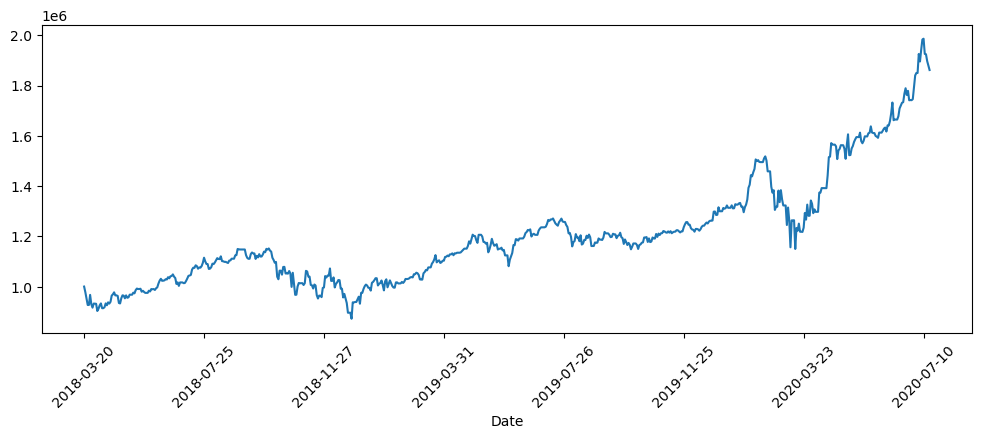

In [41]:
my_book['value'].plot(figsize=(12,4), rot=45)
print(f"your gain: {my_book['value'].iloc[-1]/my_book['value'].iloc[0]}")

In [42]:
my_book

,Open_amzn,AdjClose_amzn,Open_msft,AdjClose_msft,Open_goog,AdjClose_goog,o(a),o(m),o(g),cash,u(a),u(m),u(g),value
Date,,,,,,,,,,,,,,
2018-03-20,77.52,79.33,93.05,87.18,54.95,54.89,30.00,30.00,30.00,1000000.00,0,0,0,1000000.00
2018-03-21,79.32,79.09,92.93,86.57,54.64,54.54,30.00,30.00,30.00,100067.12,3782,3228,5490,978090.71
2018-03-22,78.27,77.25,91.27,84.05,54.09,52.45,29.90,29.90,29.90,98892.66,3785,3246,5477,951391.14
2018-03-23,76.95,74.78,89.50,81.61,52.35,51.08,29.85,29.85,29.85,99799.95,3758,3231,5525,926701.42
2018-03-25,76.95,74.78,89.50,81.61,52.35,51.08,29.85,29.85,29.85,101232.67,3752,3226,5515,926766.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-13,162.55,155.20,214.48,200.27,77.50,75.57,55.58,43.47,0.95,9007.25,6997,4149,0,1925872.07
2020-07-14,154.45,154.20,206.13,201.51,74.52,76.03,55.43,43.32,0.80,210.10,6998,4102,246,1924600.69
2020-07-15,154.01,150.44,209.56,201.21,76.16,75.68,54.55,42.65,2.80,9094.67,7040,4044,204,1897351.63


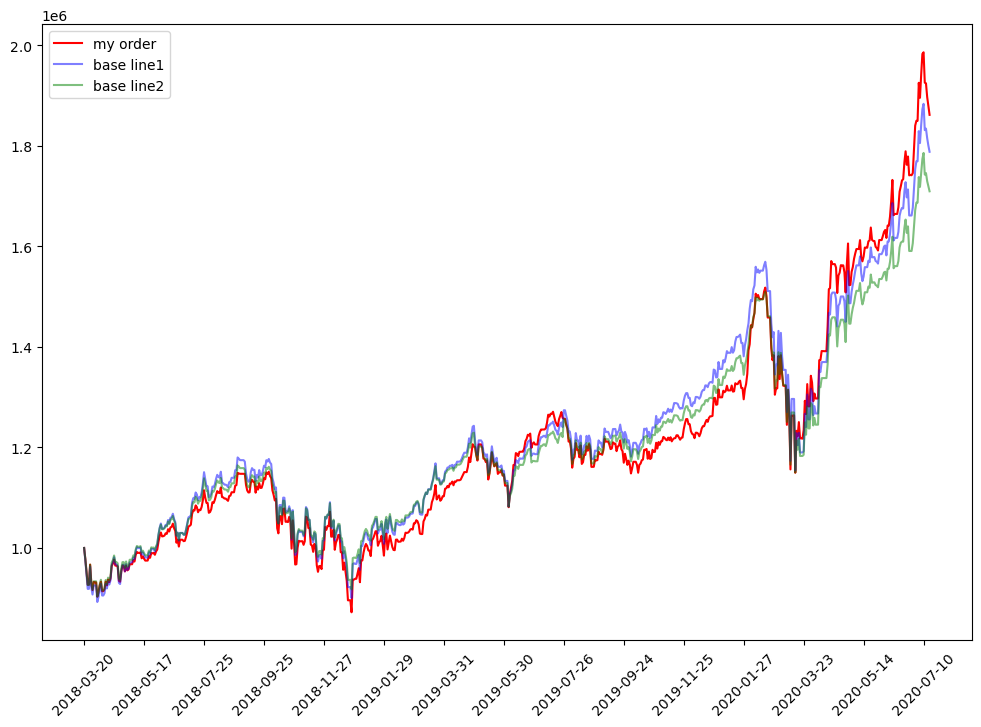

In [62]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1)
plt.plot(my_book.index, my_book['value'], label = "my order", color='red', alpha=1.0)
plt.plot(bl1_book.index, bl1_book['value'], label = "base line1", color='blue', alpha=0.5)
plt.plot(bl2_book.index, bl2_book['value'], label = "base line2", color='green', alpha=0.5)
plt.xticks(rotation = 45)
ax.set_xticks(ax.get_xticks()[::50])
plt.legend() 
plt.show()

In [44]:
bl1_gain = bl1_book['value'].iloc[-1]/bl1_book['value'].iloc[0]
bl2_gain = bl2_book['value'].iloc[-1]/bl2_book['value'].iloc[0]
your_gain = my_book['value'].iloc[-1]/my_book['value'].iloc[0]
print(f"your gain: {your_gain}")
print(f"base line1 gain: {bl1_gain} yourgain/bl1 ratio: {your_gain/bl1_gain}")
print(f"base line2 gain: {bl2_gain} yourgain/bl2 ratio {your_gain/bl2_gain}")

your gain: 1.8618508440069952
base line1 gain: 1.788351578092 yourgain/bl1 ratio: 1.0410988906294432
base line2 gain: 1.7097508662939989 yourgain/bl2 ratio 1.088960316214188


<Axes: xlabel='Date'>

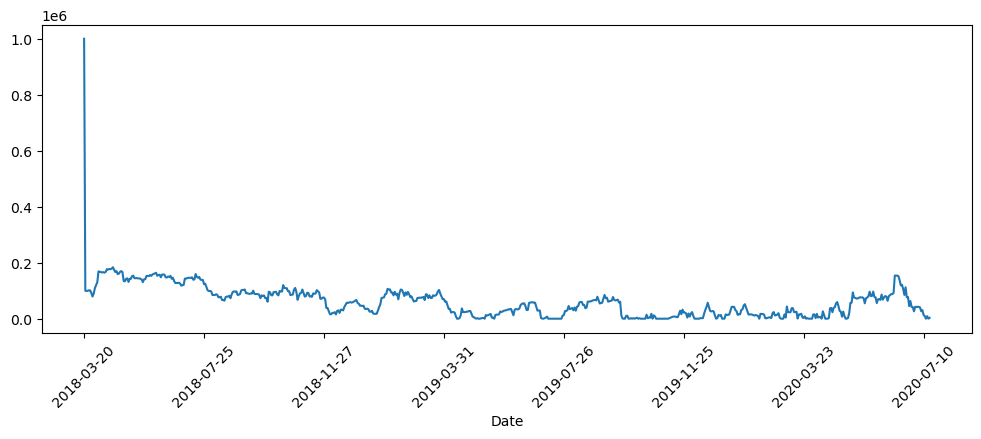

In [45]:
my_book['cash'].plot(figsize=(12,4), rot=45)

In [46]:
'''

back up section

'''

'\n\nback up section\n\n'

In [47]:
'''
base line
'''

'\nbase line\n'

In [48]:
#initial cash
initial_cash = 1000000

In [49]:
book = df[['Open_amzn', 'AdjClose_amzn', 'Open_msft', 'AdjClose_msft', 'Open_goog', 'AdjClose_goog']].copy()

In [50]:
#book = book.iloc[:10]
book

,Open_amzn,AdjClose_amzn,Open_msft,AdjClose_msft,Open_goog,AdjClose_goog
Date,,,,,,
2018-03-20,77.52,79.33,93.05,87.18,54.95,54.89
2018-03-21,79.32,79.09,92.93,86.57,54.64,54.54
2018-03-22,78.27,77.25,91.27,84.05,54.09,52.45
2018-03-23,76.95,74.78,89.50,81.61,52.35,51.08
2018-03-25,76.95,74.78,89.50,81.61,52.35,51.08
...,...,...,...,...,...,...
2020-07-13,162.55,155.20,214.48,200.27,77.50,75.57
2020-07-14,154.45,154.20,206.13,201.51,74.52,76.03
2020-07-15,154.01,150.44,209.56,201.21,76.16,75.68


In [51]:
book['o(a)'] = np.nan
book['o(m)'] = np.nan
book['o(g)'] = np.nan
book['cash'] = 0.0
book['u(a)'] = 0
book['u(m)'] = 0
book['u(g)'] = 0
book['value'] = 0.0

book.loc[book.index[0], 'cash'] = initial_cash
book.loc[book.index[0], 'value'] = book.loc[book.index[0], 'cash'] \
    + book.loc[book.index[0], 'AdjClose_amzn'] * book.loc[book.index[0], 'u(a)'] \
    + book.loc[book.index[0], 'AdjClose_msft'] * book.loc[book.index[0], 'u(m)'] \
    + book.loc[book.index[0], 'AdjClose_goog'] * book.loc[book.index[0], 'u(g)']

In [52]:
book

,Open_amzn,AdjClose_amzn,Open_msft,AdjClose_msft,Open_goog,AdjClose_goog,o(a),o(m),o(g),cash,u(a),u(m),u(g),value
Date,,,,,,,,,,,,,,
2018-03-20,77.52,79.33,93.05,87.18,54.95,54.89,NaN,NaN,NaN,1000000.00,0,0,0,1000000.00
2018-03-21,79.32,79.09,92.93,86.57,54.64,54.54,NaN,NaN,NaN,0.00,0,0,0,0.00
2018-03-22,78.27,77.25,91.27,84.05,54.09,52.45,NaN,NaN,NaN,0.00,0,0,0,0.00
2018-03-23,76.95,74.78,89.50,81.61,52.35,51.08,NaN,NaN,NaN,0.00,0,0,0,0.00
2018-03-25,76.95,74.78,89.50,81.61,52.35,51.08,NaN,NaN,NaN,0.00,0,0,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-13,162.55,155.20,214.48,200.27,77.50,75.57,NaN,NaN,NaN,0.00,0,0,0,0.00
2020-07-14,154.45,154.20,206.13,201.51,74.52,76.03,NaN,NaN,NaN,0.00,0,0,0,0.00
2020-07-15,154.01,150.44,209.56,201.21,76.16,75.68,NaN,NaN,NaN,0.00,0,0,0,0.00


In [53]:
# place a sample order
book.loc['2018-03-20', 'o(a)'] = 30.0
book.loc['2018-03-20', 'o(m)'] = 30.0
book.loc['2018-03-20', 'o(g)'] = 30.0


In [54]:
book

,Open_amzn,AdjClose_amzn,Open_msft,AdjClose_msft,Open_goog,AdjClose_goog,o(a),o(m),o(g),cash,u(a),u(m),u(g),value
Date,,,,,,,,,,,,,,
2018-03-20,77.52,79.33,93.05,87.18,54.95,54.89,30.00,30.00,30.00,1000000.00,0,0,0,1000000.00
2018-03-21,79.32,79.09,92.93,86.57,54.64,54.54,NaN,NaN,NaN,0.00,0,0,0,0.00
2018-03-22,78.27,77.25,91.27,84.05,54.09,52.45,NaN,NaN,NaN,0.00,0,0,0,0.00
2018-03-23,76.95,74.78,89.50,81.61,52.35,51.08,NaN,NaN,NaN,0.00,0,0,0,0.00
2018-03-25,76.95,74.78,89.50,81.61,52.35,51.08,NaN,NaN,NaN,0.00,0,0,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-13,162.55,155.20,214.48,200.27,77.50,75.57,NaN,NaN,NaN,0.00,0,0,0,0.00
2020-07-14,154.45,154.20,206.13,201.51,74.52,76.03,NaN,NaN,NaN,0.00,0,0,0,0.00
2020-07-15,154.01,150.44,209.56,201.21,76.16,75.68,NaN,NaN,NaN,0.00,0,0,0,0.00


In [55]:
'''
book.loc['2018-03-26', 'o(a)'] = 40.0
book.loc['2018-03-26', 'o(m)'] = 30.0
book.loc['2018-03-26', 'o(g)'] = 20.0
book
'''

"\nbook.loc['2018-03-26', 'o(a)'] = 40.0\nbook.loc['2018-03-26', 'o(m)'] = 30.0\nbook.loc['2018-03-26', 'o(g)'] = 20.0\nbook\n"

In [56]:
book['o(a)'] = book['o(a)'].ffill()
book['o(m)'] = book['o(m)'].ffill()
book['o(g)'] = book['o(g)'].ffill()

In [57]:
book

,Open_amzn,AdjClose_amzn,Open_msft,AdjClose_msft,Open_goog,AdjClose_goog,o(a),o(m),o(g),cash,u(a),u(m),u(g),value
Date,,,,,,,,,,,,,,
2018-03-20,77.52,79.33,93.05,87.18,54.95,54.89,30.00,30.00,30.00,1000000.00,0,0,0,1000000.00
2018-03-21,79.32,79.09,92.93,86.57,54.64,54.54,30.00,30.00,30.00,0.00,0,0,0,0.00
2018-03-22,78.27,77.25,91.27,84.05,54.09,52.45,30.00,30.00,30.00,0.00,0,0,0,0.00
2018-03-23,76.95,74.78,89.50,81.61,52.35,51.08,30.00,30.00,30.00,0.00,0,0,0,0.00
2018-03-25,76.95,74.78,89.50,81.61,52.35,51.08,30.00,30.00,30.00,0.00,0,0,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-13,162.55,155.20,214.48,200.27,77.50,75.57,30.00,30.00,30.00,0.00,0,0,0,0.00
2020-07-14,154.45,154.20,206.13,201.51,74.52,76.03,30.00,30.00,30.00,0.00,0,0,0,0.00
2020-07-15,154.01,150.44,209.56,201.21,76.16,75.68,30.00,30.00,30.00,0.00,0,0,0,0.00


In [58]:
order_date = book.index[0]
#print(order_date)
for date in book.index[1:]:
    #print(date)
    value = book.loc[order_date, 'cash']
    # for simple calculation, sell all at same price to buy then rebuy as order
    value += book.loc[order_date, 'u(a)'] * book.loc[date, 'Open_amzn']
    value += book.loc[order_date, 'u(m)'] * book.loc[date, 'Open_msft']
    value += book.loc[order_date, 'u(g)'] * book.loc[date, 'Open_goog']
    #print("value:" + str(value))
    cash = value
    # buy as order
    order = book.loc[order_date, 'o(a)']
    price = book.loc[date, 'Open_amzn']
    pay = value * order / 100
    book.loc[date, 'u(a)'] = pay // price
    cash = cash - pay + (pay % price)
    #print(f"a o:{order} p:{price} pay:{pay} u(a): {book.loc[date, 'u(a)']} cash: {cash}")
    
    order = book.loc[order_date, 'o(m)']
    price = book.loc[date, 'Open_msft']
    pay = value * order / 100
    book.loc[date, 'u(m)'] = pay // price
    cash = cash - pay + (pay % price)
    #print(f"m o:{order} p:{price} pay:{pay} u(m): {book.loc[date, 'u(m)']} cash: {cash}")
    
    order = book.loc[order_date, 'o(g)']
    price = book.loc[date, 'Open_goog']
    pay = value * order / 100
    book.loc[date, 'u(g)'] = pay // price
    cash = cash - pay + (pay % price)
    #print(f"g o:{order} p:{price} pay:{pay} u(g): {book.loc[date, 'u(g)']} cash: {cash}")
    
    book.loc[date, 'cash'] = cash
    book.loc[date, 'value'] = book.loc[date, 'cash'] \
        + book.loc[date, 'u(a)'] * book.loc[date, 'AdjClose_amzn'] \
        + book.loc[date, 'u(m)'] * book.loc[date, 'AdjClose_msft'] \
        + book.loc[date, 'u(g)'] * book.loc[date, 'AdjClose_goog']
    #print(f"cash {cash} value {book.loc[date, 'value']}")
    # set order date for the next day
    order_date = date
        
    

In [59]:
book

,Open_amzn,AdjClose_amzn,Open_msft,AdjClose_msft,Open_goog,AdjClose_goog,o(a),o(m),o(g),cash,u(a),u(m),u(g),value
Date,,,,,,,,,,,,,,
2018-03-20,77.52,79.33,93.05,87.18,54.95,54.89,30.00,30.00,30.00,1000000.00,0,0,0,1000000.00
2018-03-21,79.32,79.09,92.93,86.57,54.64,54.54,30.00,30.00,30.00,100067.12,3782,3228,5490,978090.71
2018-03-22,78.27,77.25,91.27,84.05,54.09,52.45,30.00,30.00,30.00,98892.66,3785,3246,5477,951391.14
2018-03-23,76.95,74.78,89.50,81.61,52.35,51.08,30.00,30.00,30.00,96872.77,3771,3242,5543,926563.45
2018-03-25,76.95,74.78,89.50,81.61,52.35,51.08,30.00,30.00,30.00,96872.77,3771,3242,5543,926563.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-13,162.55,155.20,214.48,200.27,77.50,75.57,30.00,30.00,30.00,182096.07,3353,2541,7034,1742912.27
2020-07-14,154.45,154.20,206.13,201.51,74.52,76.03,30.00,30.00,30.00,175047.88,3395,2543,7036,1745937.99
2020-07-15,154.01,150.44,209.56,201.21,76.16,75.68,30.00,30.00,30.00,176761.24,3441,2529,6959,1729969.92


<Axes: xlabel='Date'>

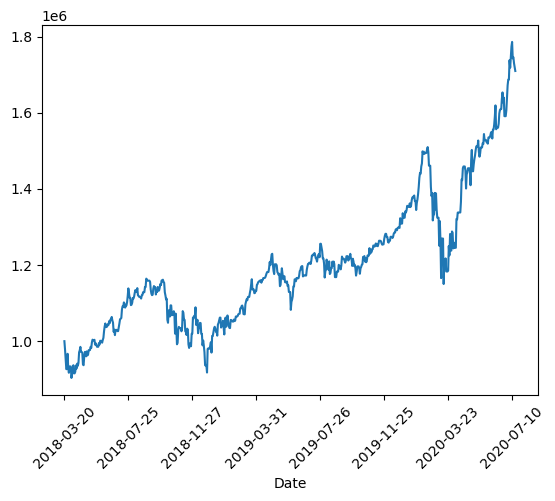

In [60]:
book['value'].plot(rot=45)

In [61]:
print(f"your gain: {book['value'].iloc[-1]/book['value'].iloc[0]}")

your gain: 1.7097508662939989
